In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

c:\Users\patri\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
transform = transforms.ToTensor() # definindo a conversão de imagem para tensor
trainset = datasets.MNIST('.MNIST_data/', download=True, train=True, transform=transform) # baixando o dataset de treino
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # carregando o dataset de treino

valset = datasets.MNIST('.MNIST_data/', download=True, train=False, transform=transform) # baixando o dataset de validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # carregando o dataset de validação

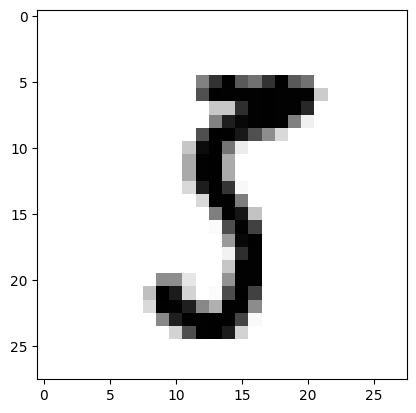

In [3]:
dataiter = iter(trainloader) # iterador para o dataset de treino
imagens, etiquetas = next(dataiter) # carregando um batch de imagens e etiquetas
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r') # mostrando a primeira imagem do batch

In [4]:
print(imagens[0].shape) # para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # para verificar as forma do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [5]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada
        self.linear2 = nn.Linear(128, 64) # camada interna 1
        self.linear3 = nn.Linear(64, 10) # camada de interna 2
    
    def forward(self, x):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # função de ativação de camada interna 2 para a camada de saída
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [6]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a política de atualização dos pesos
    inicio = time() # inicia a contagem do tempo

    criterio = nn.NLLLoss() # definindo o critério para calcular a perda
    EPOCHS = 5 # numero de epochs que o algoritmo rodará
    modelo.train() # define o modelo como mode de treino

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casa para ficarem compatíveis com a entrada da rede
            otimizador.zero_grad() # zerando o gradiente

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

            perda_instantanea.backward() # back propagation a partiur da perda

            otimizador.step() #atualizando os pesos e a bias

            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada

        else:
            print(f'Perda da epoch {epoch+1}: {perda_acumulada/len(trainloader)}')
    print(f'Tempo de treino: {time()-inicio}')

In [7]:
def validacao (modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # output do modelo em escala logarítmica

            
            ps = torch.exp(logps) # converte a saída do modelo para a escala normal(lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo acha que é a etiqueta
            etiqueta_certa = etiquetas.numpy()[i]
            if etiqueta_certa == etiqueta_pred:
                conta_corretas += 1
            
    print(f'Total de imagens testadas = {conta_todas}')
    print(f'\nPrecisão do modelo = {conta_corretas*100/conta_todas}')

In [8]:
modelo = Modelo() # instanciando o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # definindo o dispositivo de processamento
modelo.to(device) # colocando o modelo no dispositivo de processamento

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)